In [5]:
import pandas as pd
labels = pd.read_csv(r'C:\Users\Admin\Downloads\archive\trainLabels_cropped.csv')
labels.head()

,Unnamed: 0.1,Unnamed: 0,image,level
0,0,0,10_left,0
1,1,1,10_right,0
2,2,2,13_left,0
3,3,3,13_right,0
4,4,4,15_left,1


In [6]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
import ray
!pip show ray

Name: ray
Version: 2.47.0
Summary: Ray provides a simple, universal API for building distributed applications.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: C:\Users\Admin\anaconda3\envs\new\Lib\site-packages
Requires: click, filelock, jsonschema, msgpack, packaging, protobuf, pyyaml, requests
Required-by: 


In [4]:
!python --version

Python 3.12.7


In [4]:
!conda info --envs


# conda environments:
#
base                 * C:\Users\Admin\anaconda3
env                    C:\Users\Admin\anaconda3\envs\env



In [3]:
import tensorflow

In [23]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
# Set directory paths
DIRECTORY = r'C:\Users\Admin\Downloads\archive\resized_train_cropped\resized_train_cropped'
LABELS_FILE = r'C:\Users\Admin\Downloads\archive\trainLabels_cropped.csv'

# Load labels
labels_df = pd.read_csv(LABELS_FILE)
labels_dict = dict(zip(labels_df['image'], labels_df['level']))

# Load images and labels
images = []
labels = []

train_image_count = 0

import re

# ...

for filename in os.listdir(DIRECTORY):
    if filename.endswith('.jpeg') and train_image_count < 10000:
        train_image_count += 1
        img = load_img(os.path.join(DIRECTORY, filename), target_size=(256, 256))
        img_array = img_to_array(img) / 255.0
        images.append(img_array)

        base_name = re.sub(r'\s*\(.*\)', '', filename.split('.')[0])
        label = labels_dict.get(base_name)

        if label is not None:
            labels.append(label)
        else:
            # Skip image if label is not found
            images.pop()  # remove the image you just added


images = np.array(images)
labels = np.array(labels)

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=5)  # Assuming there are 5 levels of diabetic retinopathy
print("done")

In [24]:
images.shape

(10000, 256, 256, 3)

In [25]:
labels.shape

(10000, 5)

In [26]:
from sklearn.model_selection import train_test_split

# Split with one single test sample
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=1, random_state=42, shuffle=True
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")   # Should be (1, 256, 256, 3)
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")   # Should be (1, 5)


X_train shape: (9999, 256, 256, 3)
X_test shape: (1, 256, 256, 3)
y_train shape: (9999, 5)
y_test shape: (1, 5)


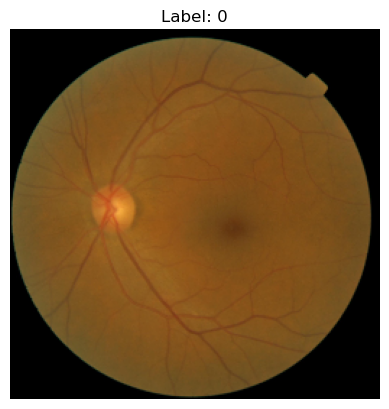

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(X_test[0])
plt.title(f"Label: {np.argmax(y_test[0])}")  # Convert from one-hot to class index
plt.axis('off')
plt.show()

In [28]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))  # Shape: (n_train, 256*256*3)
X_test_flat = X_test.reshape((X_test.shape[0], -1))     # Shape: (1, 256*256*3)
y_train_classes = np.argmax(y_train, axis=1)  # Shape: (n_train,)
y_test_classes = np.argmax(y_test, axis=1)    # Shape: (1,)

In [29]:
X_train_flat.shape

(9999, 196608)

In [32]:
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(X_train_flat, y_train_classes)

debut = time.perf_counter()
# Predict on the test image
y_pred = knn.predict(X_test_flat)
fin = time.perf_counter()
# Print results

print(f'temps de prédiction = {fin-debut:.4f} secondes')
print(f"Predicted label: {y_pred[0]}")
print(f"True label: {y_test_classes[0]}")
print(f"Correct? {'✅' if y_pred[0] == y_test_classes[0] else '❌'}")


temps de prédiction = 31.1257 secondes
Predicted label: 0
True label: 0
Correct? ✅


my sequential knn

In [87]:
import numpy as np
from collections import Counter

class knn:
    def __init__(self, k):
        self.k = k

    def fitt(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def predire(self, test_sample):
        #test_sample = np.array(test_sample).ravel()
        # Vectorized Euclidean distance: sqrt(sum((x_train - test_sample)^2))
        distances = np.sqrt(np.sum((self.x_train - test_sample)**2, axis=1))
        print(f'thread {threading.get_ident()} calcule {len(distances)} distances')
        # Get indices of k smallest distances
        k_indices = np.argpartition(distances, self.k)[:self.k]

        # Get the labels of those k neighbors
        k_nearest_labels = self.y_train[k_indices]

        # Return the most common label
        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

In [88]:
knn_model = knn(k=5)
knn_model.fitt(X_train_flat, y_train_classes)

In [89]:
import time
import threading
debut = time.perf_counter()
prediction = knn_model.predire(X_test_flat[0])
fin = time.perf_counter()
print(f'temps de prédiction = {fin-debut:.4f} secondes')
print(f"Predicted label: {prediction}")
print(f"True label: {y_test_classes[0]}")
print(f"Correct? {'✅' if prediction == y_test_classes[0] else '❌'}")

thread 20824 calcule 9999 distances
temps de prédiction = 85.6523 secondes
Predicted label: 0
True label: 0
Correct? ✅


ray

In [90]:
import psutil
import threading
import numpy as np
from collections import Counter
import ray

# Initialisation de Ray
import os
os.environ["RAY_LOG_TO_STDERR"] = "1"
ray.init(ignore_reinit_error=True, num_cpus=8, log_to_driver=True, include_dashboard=False)

@ray.remote(num_cpus=1)
def compute_distances_chunk(x_chunk, test_sample):
    #time.sleep(5)
    #test_sample = np.array(test_sample).ravel()
    # Calcul des distances Euclidiennes entre un test_sample et un chunk de x_train
    pid = os.getpid()
    memory = psutil.Process(pid).memory_info().rss / 1024**2  # in MB
    distances = np.sqrt(np.sum((x_chunk - test_sample) ** 2, axis=1))
    log_message = f'PID: {os.getpid()}, thread {threading.get_ident()} a calculé {len(distances)} distances, memoire {memory} MB utilisé, cpu percent{psutil.cpu_percent()}'
    return distances, log_message

class KNNRayDistanceParallel:
    def __init__(self, k=3, n_chunks=8):
        self.k = k
        self.n_chunks = n_chunks

    def fitt(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def predire(self, test_sample):
        # Diviser x_train en morceaux
        chunks = np.array_split(self.x_train, self.n_chunks)

        # Lancer en parallèle le calcul des distances
        futures = [compute_distances_chunk.remote(chunk, test_sample) for chunk in chunks]
        # Récupération
        result_chunks_and_logs = ray.get(futures)
        result_chunks, logs = zip(*result_chunks_and_logs)  # unpack tuples

        # Afficher les logs
        for log in logs:
            print(log)

        # Concaténer toutes les distances
        distances = np.concatenate(result_chunks)

        # Trouver les k plus proches voisins
        k_indices = np.argpartition(distances, self.k)[:self.k]
        k_labels = self.y_train[k_indices]

        # Retourner la classe majoritaire
        most_common = Counter(k_labels).most_common(1)[0][0]
        return most_common

2025-07-27 16:42:39,724	INFO worker.py:1747 -- Calling ray.init() again after it has already been called.


In [91]:
knn_ray = KNNRayDistanceParallel(k=5)
knn_ray.fitt(X_train_flat, y_train_classes)

In [92]:
import time
debut = time.perf_counter()
prediction = knn_ray.predire(X_test_flat[0])
fin = time.perf_counter()
print(f'temps d execution : {fin-debut} secondes')
print(prediction == y_test_classes[0])

PID: 5652, thread 17628 a calculé 1250 distances, memoire 23.38671875 MB utilisé, cpu percent20.7
PID: 19060, thread 7712 a calculé 1250 distances, memoire 22.921875 MB utilisé, cpu percent20.8
PID: 19060, thread 7712 a calculé 1250 distances, memoire 962.9765625 MB utilisé, cpu percent30.3
PID: 5652, thread 17628 a calculé 1250 distances, memoire 963.37109375 MB utilisé, cpu percent30.8
PID: 5652, thread 17628 a calculé 1250 distances, memoire 995.4140625 MB utilisé, cpu percent31.8
PID: 19060, thread 7712 a calculé 1250 distances, memoire 1932.41015625 MB utilisé, cpu percent32.5
PID: 5652, thread 17628 a calculé 1250 distances, memoire 1932.93359375 MB utilisé, cpu percent36.9
PID: 19060, thread 7712 a calculé 1249 distances, memoire 1933.1328125 MB utilisé, cpu percent36.1
temps d execution : 24.077117200009525 secondes
True


In [39]:
psutil.cpu_percent()

17.4

In [40]:
psutil.Process().memory_info()

pmem(rss=8197341184, vms=16298520576, num_page_faults=22486880, peak_wset=17953607680, wset=8197341184, peak_paged_pool=12551616, paged_pool=11568624, peak_nonpaged_pool=454256, nonpaged_pool=290200, pagefile=16298520576, peak_pagefile=17087352832, private=16298520576)

In [43]:
print(ray.available_resources())

{'accelerator_type:G': 1.0, 'node:__internal_head__': 1.0, 'CPU': 8.0, 'memory': 7968310068.0, 'node:127.0.0.1': 1.0, 'object_store_memory': 3414990028.0, 'GPU': 1.0}


In [93]:
ray.shutdown()

In [3]:
!pip show ray

Name: ray
Version: 2.47.0
Summary: Ray provides a simple, universal API for building distributed applications.
Home-page: https://github.com/ray-project/ray
Author: Ray Team
Author-email: ray-dev@googlegroups.com
License: Apache 2.0
Location: C:\Users\Admin\anaconda3\envs\new\Lib\site-packages
Requires: click, filelock, jsonschema, msgpack, packaging, protobuf, pyyaml, requests
Required-by: 


In [3]:
import os
os.cpu_count()

16

In [1]:
'''import ray
import os
import threading
os.environ["RAY_LOG_TO_STDERR"] = "1"
ray.init(ignore_reinit_error=True, num_cpus=6, log_to_driver=True, include_dashboard=False)
print(os.cpu_count())
#parallel ray
import time
@ray.remote
def mult(x):
  time.sleep(5)
  print('\n')
  return f'résultat = {x*x} calculé par thread {threading.get_ident()}'

futures = [mult.remote(i) for i in range(4)]

begin = time.perf_counter()
print(ray.get(futures))
end = time.perf_counter()
print(f'Temps d\'exécution ray.get : {end-begin} secondes')'''

2025-07-27 15:31:36,904	INFO worker.py:1917 -- Started a local Ray instance.


16
['résultat = 0 calculé par thread 412', 'résultat = 1 calculé par thread 18560', 'résultat = 4 calculé par thread 19256', 'résultat = 9 calculé par thread 3080']
Temps d'exécution ray.get : 5.056273800088093 secondes


In [18]:
print(threading.current_thread().ident)

21236


In [37]:
import psutil
print(threading.get_native_id())

21236


In [34]:
threading.enumerate()

[<_MainThread(MainThread, started 21236)>,
 <Thread(IOPub, started daemon 4476)>,
 <Heartbeat(Heartbeat, started daemon 14516)>,
 <Thread(Tornado selector, started daemon 11984)>,
 <ControlThread(Control, started daemon 12952)>,
 <Thread(Tornado selector, started daemon 19068)>,
 <HistorySavingThread(IPythonHistorySavingThread, started 9940)>,
 <ParentPollerWindows(Thread-4, started daemon 14924)>,
 <Thread(Tornado selector, started daemon 16104)>,
 <GarbageCollectorThread(Thread-5, started daemon 20800)>,
 <Thread(ray_listen_error_messages, started daemon 12688)>,
 <Thread(ray_print_logs, started daemon 19668)>]

dask

In [47]:
!pip install dask

In [102]:
from dask.distributed import Client
import numpy as np
from collections import Counter
import threading

# Initialisation du client Dask (utilisation de threads)
client = Client(threads_per_worker=4, n_workers=1)

In [103]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 23.71 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60166,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:60173,Total threads: 4
Dashboard: http://127.0.0.1:60174/status,Memory: 23.71 GiB
Nanny: tcp://127.0.0.1:60169,


In [104]:
# Fonction de calcul des distances
def compute_distances_chunk(x_chunk, test_sample):
    #test_sample = np.array(test_sample).ravel()
    distances = np.sqrt(np.sum((x_chunk - test_sample) ** 2, axis=1))
    log_message = f'thread {threading.get_ident()} a calculé {len(distances)} distances.'
    return distances, log_message

class KNNDaskDistanceParallel:
    def __init__(self, k=3, n_chunks=4):
        self.k = k
        self.n_chunks = n_chunks

    def fitt(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

    def predire(self, test_sample):
        # Diviser x_train en morceaux
        chunks = np.array_split(self.x_train, self.n_chunks)

        # Distribuer les données (scatter)
        scattered_chunks = client.scatter(chunks)

        # Mapper la fonction de distance
        futures = [client.submit(compute_distances_chunk, chunk, test_sample) for chunk in scattered_chunks]

        # Récupérer les résultats (gather)
        result_chunks_and_logs = client.gather(futures)
        result_chunks, logs = zip(*result_chunks_and_logs)

        # Afficher les logs
        for log in logs:
            print(log)

        # Concaténer toutes les distances
        distances = np.concatenate(result_chunks)

        # Trouver les k plus proches voisins
        k_indices = np.argpartition(distances, self.k)[:self.k]
        k_labels = self.y_train[k_indices]

        # Retourner la classe majoritaire
        most_common = Counter(k_labels).most_common(1)[0][0]
        return most_common


In [105]:
knn_dask = KNNDaskDistanceParallel(k=5)
knn_dask.fitt(X_train_flat, y_train_classes)

In [106]:
import time
debut = time.perf_counter()
prediction = knn_dask.predire(X_test_flat[0])
fin = time.perf_counter()
print(f'temps d execution : {fin-debut} secondes')
print(prediction == y_test_classes[0])

thread 21352 a calculé 2500 distances.
thread 18976 a calculé 2500 distances.
thread 20544 a calculé 2500 distances.
thread 3664 a calculé 2499 distances.
temps d execution : 167.68494149995968 secondes
True


In [107]:
client.close()